# Code for analyzing volume output
- Uses CSV generated by "collect_volumes.sh" script part of [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes) 


In [63]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nibabel as nib

sys.path.append('../')
from lib.stats_utils import *

### Paths

In [2]:
project_dir = '../../../'
data_dir = project_dir + 'data/preproc_T1s/'
results_dir = '../results/MAGeT/'

### Grab total brain volumes from the masks

In [3]:
groups = ['NC','ET']
grp = 'NC'

mask_df = pd.DataFrame(columns=['Subject','group','brain_volume'])

i = 0
for grp in groups:
    mask_dir = data_dir + '{}/masks/'.format(grp)

    mask_paths = os.listdir(mask_dir)

    for m, mask_path in enumerate(mask_paths):
        sub_name = mask_path.rsplit('-',1)[0]
        mask_path = mask_dir + sub_name + '-brain_mask.nii.gz' 
        
        # load anothor image to mask
        mask = nib.load(mask_path)
        mask_data = mask.get_data()
        mask_df.loc[i] = [sub_name.split('_',1)[0], grp, np.sum(mask_data.ravel())]
        i=i+1
        
mask_df.head()

,Subject,group,brain_volume
0,sub-0062,NC,1571150
1,sub-0104,NC,1428372
2,sub-0058,NC,1228322
3,sub-0078,NC,1354347
4,sub-0080,NC,1407550


### Grab cerebellum volumes from segmentations

In [4]:

cols_L = ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I','L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM']
cols_R = ['R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II','R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']

vol_df_concat = pd.DataFrame()
for grp in groups:
    vol_df = pd.read_csv('{}{}_volumes.csv'.format(results_dir,grp))
    vol_df['group'] = grp
    vol_df['Subject'] = vol_df['Subject'].str.split('_',expand=True)[0].str.split('/',expand=True)[1]
    vol_df['L_CB'] = vol_df[cols_L].sum(axis=1)
    vol_df['R_CB'] = vol_df[cols_R].sum(axis=1)
    vol_df_concat = vol_df_concat.append(vol_df)

vol_df_concat = pd.merge(vol_df_concat,mask_df,on=['Subject','group'],how='left')

# sort and count group sizes
vol_df_concat = vol_df_concat.sort_values(['group','Subject'])
group_sizes = vol_df_concat.value_counts(['group'])
print('Number of subjects:\n{}'.format(group_sizes))

h_lines = group_sizes.values
v_line = len(cols_L)

vol_df_concat.head()

Number of subjects:
group
ET       34
NC       33
dtype: int64


,Subject,L_I_II,L_III,L_IV,L_V,L_VI,L_Crus_I,L_Crus_II,L_VIIB,L_VIIIA,...,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,group,L_CB,R_CB,brain_volume
34,sub-0016,75.0,979.0,2700.0,4822.0,8896.0,11257.0,9249.0,3517.0,6107.0,...,5421.0,4448.0,3894.0,4662.0,599.0,7896.0,ET,64478.0,67298.0,1475141
33,sub-0061,54.0,831.0,2519.0,3625.0,7201.0,10349.0,7570.0,3509.0,5316.0,...,4871.0,3928.0,3239.0,2699.0,513.0,7526.0,ET,54314.0,57865.0,1400053
35,sub-0081,125.0,895.0,2316.0,3468.0,6315.0,11410.0,6663.0,2828.0,5304.0,...,4776.0,3606.0,3250.0,2911.0,632.0,6759.0,ET,53619.0,57589.0,1319141
36,sub-0115,56.0,744.0,2294.0,3441.0,5420.0,9979.0,7227.0,3205.0,5493.0,...,4657.0,3883.0,3039.0,3486.0,554.0,6684.0,ET,51463.0,54601.0,1245352
37,sub-0119,81.0,761.0,2063.0,3946.0,7193.0,11504.0,5921.0,2631.0,5290.0,...,4205.0,3689.0,3378.0,2805.0,539.0,7418.0,ET,53280.0,56064.0,1340808


## Plots

### Total volumes: Individuals
- Cerebellum (L and R) compared with TBV

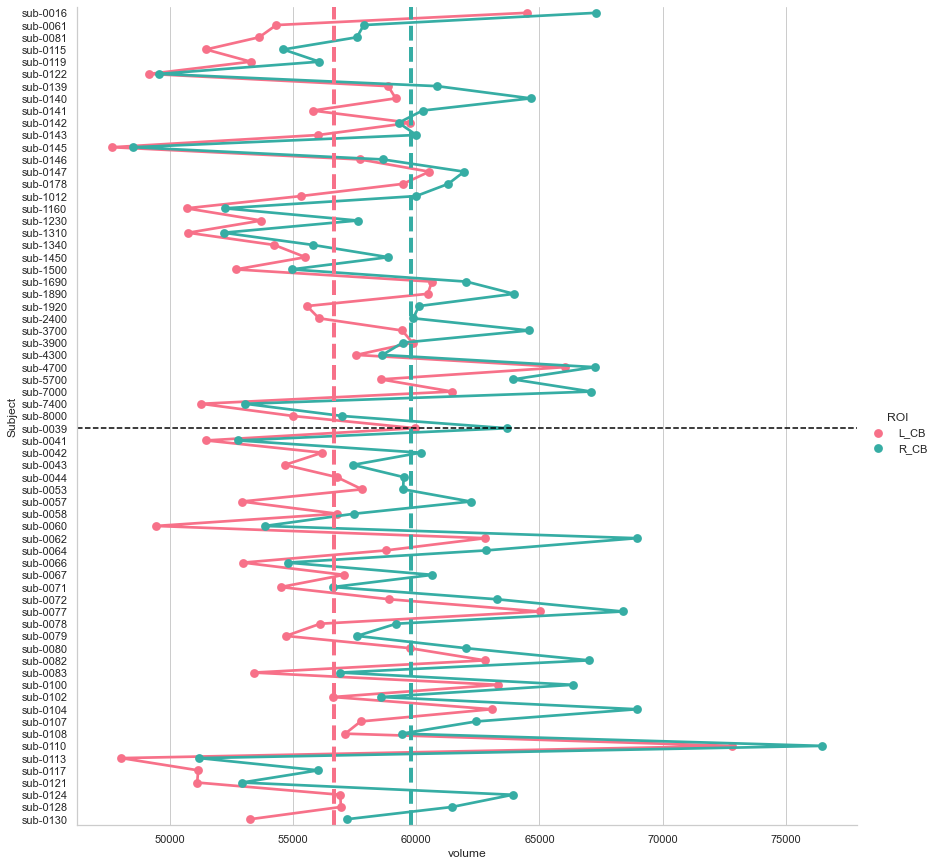

In [36]:
plot_df = vol_df_concat.copy()
plot_df[['Subject','group','L_CB','L_CB','brain_volume']]

normalize = False

if normalize:
    print('Normalizing cerebellum volume with TBV')
    plot_df['L_CB'] = plot_df['L_CB']/(0.5*plot_df['brain_volume'])
    plot_df['R_CB'] = plot_df['R_CB']/(0.5*plot_df['brain_volume'])

vol_min = np.min(plot_df[['L_CB','R_CB']].values)
vol_max = np.max(plot_df[['L_CB','R_CB']].values)
L_CB_mean = np.mean(plot_df[['L_CB']].values)
R_CB_mean = np.mean(plot_df[['R_CB']].values)

palette = sns.color_palette('husl',2)

with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Subject','group','brain_volume'], value_vars = ['L_CB','R_CB'] , 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(x='volume', y='Subject', hue='ROI', kind='point',aspect=1, height=12, palette = palette,
                    data=plot_df)

    for h_line in h_lines[:-1]:
        plt.axhline(h_line, ls='--',c='black')

    plt.axvline(L_CB_mean, ls='--',lw=4, c=palette[0])
    plt.axvline(R_CB_mean, ls='--',lw=4, c=palette[1])
    # g.set_xticklabels(rotation=50)
    if normalize:
        plt.xlabel('Volume (TBV %)')

### Total volumes: Group comparisons

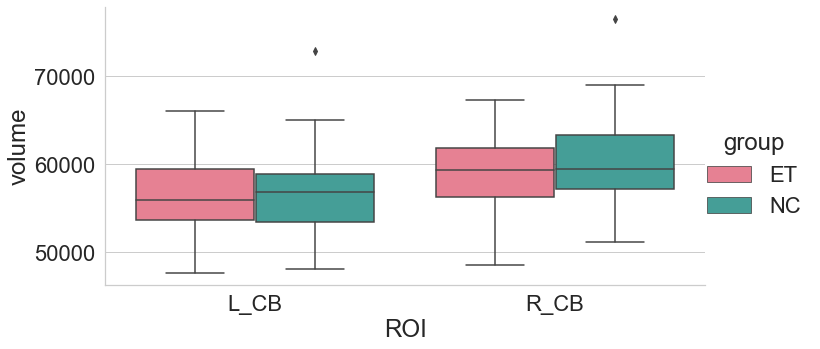

In [37]:
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=2, height=5, palette = palette,
                    data=plot_df)
    if normalize:
        plt.ylabel('Volume (TBV %)')

### ROI volumes

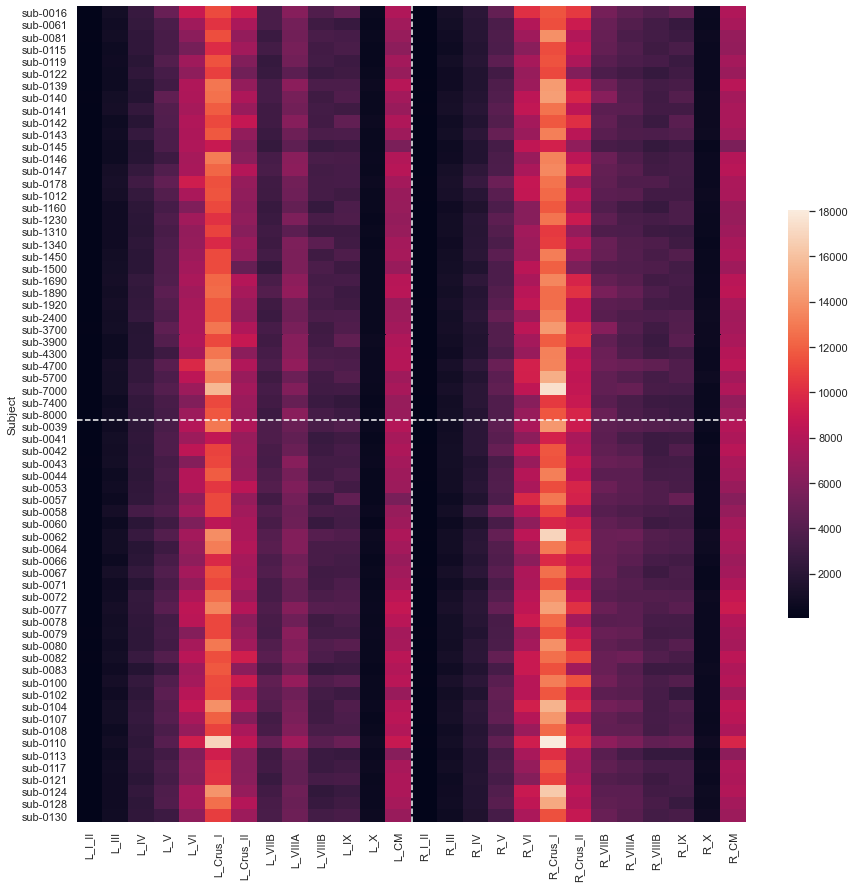

In [38]:
plot_df = vol_df_concat.copy()
plot_df = plot_df.set_index('Subject')
plot_df = plot_df[cols_L + cols_R ]
sns.set(font_scale=1)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5})

    for h_line in h_lines[:-1]:
        plt.axhline(h_line, ls='--',c='white')
    plt.axvline(v_line, ls='--',c='white')

### Group comparisons

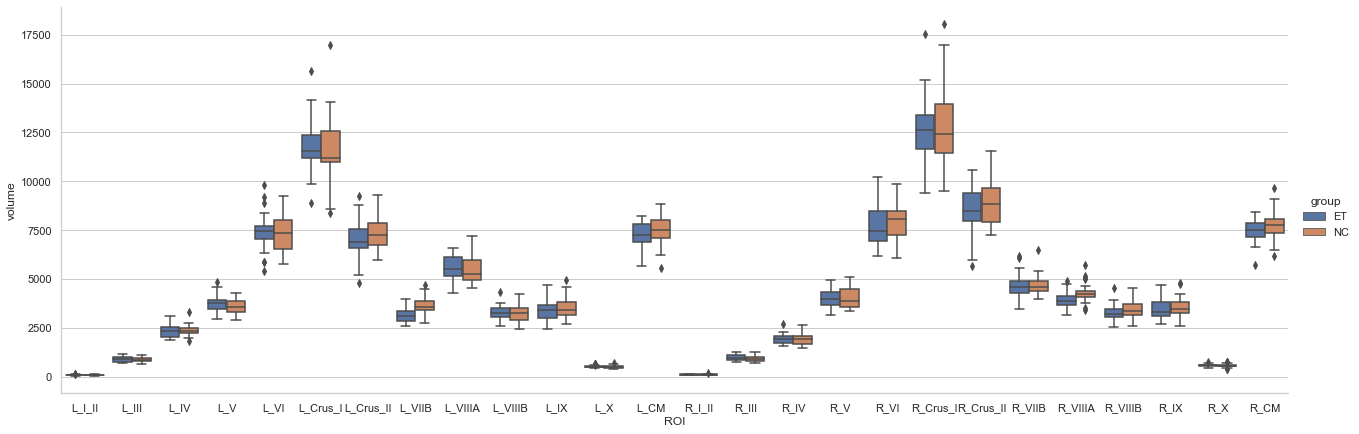

In [39]:
plot_df = vol_df_concat.copy()
plot_df = plot_df[['Subject','group'] + cols_L + cols_R]
with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Subject','group'], value_vars = cols_L + cols_R, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6,
                    data=plot_df)

 

## OLS
- Find signficant difference between NC, ET, PD groups based on ROI volumes
- Correct for multiple comparison

In [64]:
stat_df = vol_df_concat.copy()
stat_df[cols_L+cols_R+['L_CB', 'R_CB', 'brain_volume']] = stat_df[cols_L+cols_R+['L_CB', 'R_CB', 'brain_volume']].astype(int)

# regression
independent_var = 'C(group)' 
ref_level = '[T.NC]'
covars = 'brain_volume'

res_df_concat = pd.DataFrame()
for dependent_var in cols_L+cols_R:
    res = smf.ols(formula='{} ~ {} + {}'.format(dependent_var, covars, independent_var), data=stat_df).fit()
    res_df = format_ols_results(res)
    res_df['dependent_var'] = dependent_var
    res_df_concat =res_df_concat.append(res_df)

res_df_concat.head()

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var
0,Intercept,-14.855000,31.232000,-0.476,0.636,-77.247000,47.537,0.151246,0.124723,L_I_II
1,C(group)[T.NC],-6.042600,5.111000,-1.182,0.241,-16.253000,4.168,0.151246,0.124723,L_I_II
2,brain_volume,0.000075,0.000023,3.209,0.002,0.000028,0.000,0.151246,0.124723,L_I_II
0,Intercept,464.060000,193.012000,2.404,0.019,78.474000,849.646,0.069145,0.040056,L_III
1,C(group)[T.NC],-12.917600,31.587000,-0.409,0.684,-76.019000,50.184,0.069145,0.040056,L_III


Using corrected p-val threshold of 0.0019230769230769232
signficant ROIs: ['L_VIIB' 'R_VIIIA']


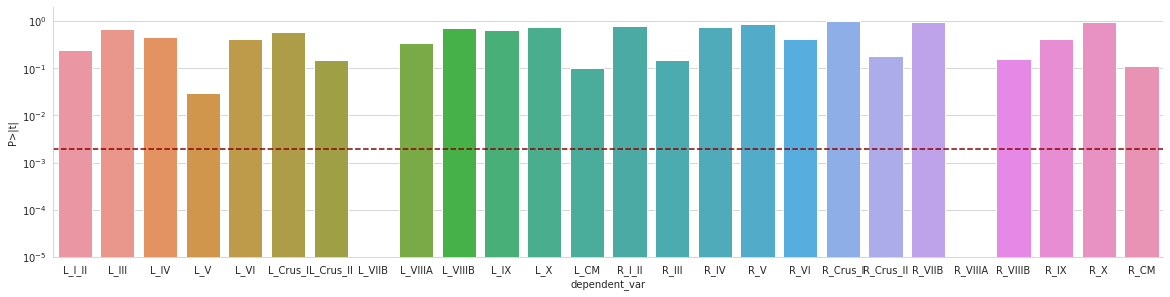

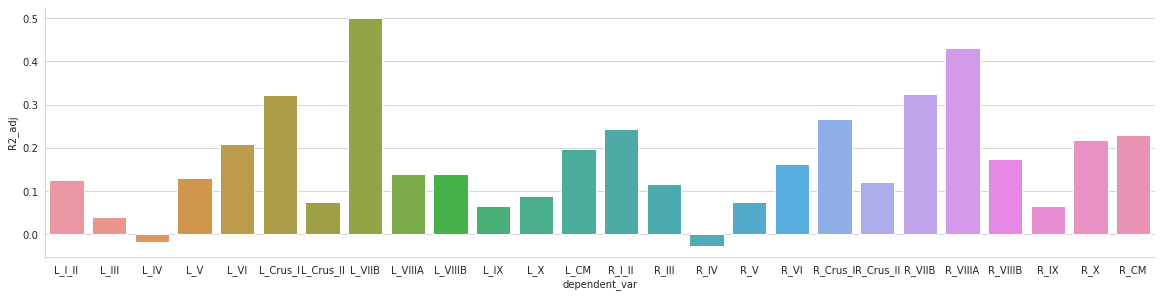

In [65]:
plot_df = res_df_concat[res_df_concat['index']=='{}{}'.format(independent_var,ref_level)].copy()
n_compare = len(cols_L+cols_R)
signific_thesh = 0.05/(n_compare)
print('Using corrected p-val threshold of {}'.format(signific_thesh))

signific_ROIs = plot_df[plot_df['P>|t|'] < signific_thesh]['dependent_var'].values
print('signficant ROIs: {}'.format(signific_ROIs))

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='P>|t|', x='dependent_var', kind='bar', aspect=4, height=4,
                    data=plot_df)
    g.set(yscale='log',ylim=(1e-5,2))
    plt.axhline(signific_thesh, ls='--',c='darkred')

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='R2_adj', x='dependent_var', kind='bar', aspect=4, height=4,
                    data=plot_df)

In [66]:
signific_df = res_df_concat[res_df_concat['dependent_var'].isin(signific_ROIs)]
signific_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var
0,Intercept,680.8494,481.399,1.414,0.162,-280.855,1642.554,0.515304,0.500157,L_VIIB
1,C(group)[T.NC],492.5935,78.781,6.253,0.000,335.210,649.978,0.515304,0.500157,L_VIIB
2,brain_volume,0.0018,0.000,5.120,0.000,0.001,0.003,0.515304,0.500157,L_VIIB
0,Intercept,910.8665,531.905,1.712,0.092,-151.736,1973.469,0.447922,0.430670,R_VIIIA
1,C(group)[T.NC],368.9140,87.047,4.238,0.000,195.018,542.810,0.447922,0.430670,R_VIIIA
2,brain_volume,0.0023,0.000,5.650,0.000,0.001,0.003,0.447922,0.430670,R_VIIIA
